In [5]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import time_evolutor as te
import plotting as p

import sys
sys.path.append('/../../temp_prog/')
import tur_calculator as tc

In [6]:
def do_all(ti_array, long_time=False):
    #------------------SETUP-------------------
    T_L = 25 
    T_R = 10
    V_B = 30
    eps = 50
    u = 250
    gamma = 1
    delta_gamma = 0.04 #0.04
    delta_epsilon = 0.04 #0.04

    INPUT = {
        'eps': eps,
        'omega': 0, 
        'u': u, 
        'V_B': V_B,
        'gamma': gamma,  
        'T_L': T_L,
        'T_R': T_R,
        'delta_gamma': delta_gamma,
        'delta_epsilon': delta_epsilon,
    }

    initial = [1/4,1/4,1/4,1/4,0,0]         #beginns with both QDs empty


    importlib.reload(te)
    sys, liouvillian, dim, eval_j, left_ev, right_ev, nleads = te.calculate_paper_meta(initial, ti_array, **INPUT, just_lio=True)

    #Theoretically calculating my_rho

    muL = -V_B/2
    muR = V_B/2

    def fermi(mu, E, T):
        return 1/(1+np.exp((E-mu)/T))

    def avg_fermi(eps):
        return (fermi(muL, eps, T_L)+fermi(muR, eps, T_R))/2

    avg_fermi_e = avg_fermi(eps)
    avg_fermi_eU = avg_fermi(eps+u)

    my_rho1 = np.zeros(dim)
    my_rho2 = np.zeros(dim)

    #filling up my_rho1:
    my_rho1[0] = 1-avg_fermi_e
    my_rho1[1] = avg_fermi_e/2
    my_rho1[2] = avg_fermi_e/2
    my_rho1[4] = avg_fermi_e/2

    #filling up my_rho2:
    my_rho2[1] = (1-avg_fermi_eU)/2
    my_rho2[2] = (1-avg_fermi_eU)/2
    my_rho2[3] = avg_fermi_eU
    my_rho2[4] = -(1-avg_fermi_eU)/2

    print('my_rho_1', my_rho1)
    print('sum', my_rho1[0]+my_rho1[1]+my_rho1[2]+my_rho1[3])
    print('my_rho_2', my_rho2)
    print('sum', my_rho2[0]+my_rho2[1]+my_rho2[2]+my_rho2[3])

    # -----------------------------PARTICLE CURRENT-------------------------------------
    # qmeq solution for stationary current (at left lead)
    I_ss = sys.current[0]

    # reset current    
    sys.current[:] = np.zeros(nleads)
    sys.energy_current[:] = np.zeros(nleads)

    # set stationary state to my_rho value
    sys.phi0[:] = np.real(my_rho1[:])

    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    J_QH_tot = sys.heat_current
    I_test = sys.current[0]
    I = sys.current_noise[0] 
    I_var = sys.current_noise[1]
    #--------------------------------------------
    # take QmeQ heat current at left lead   
    J_QH = J_QH_tot[0]

    #Power
    P = I*V_B

    importlib.reload(te)
    rho_ss, rho_t = te.time_evolution(left_ev, right_ev, eval_j, my_rho1, liouvillian, ti_array, dim)

    #plot probabilities
    plt.rcParams.update({'font.size': 16})  # Applies globally
    font_size = 20

    importlib.reload(p)
    rho_0 = rho_t[0]
    rho_1 = rho_t[1]+rho_t[2]
    rho_2 = rho_t[3]

    plt.plot(ti_array, rho_0, label=r'$P_0$')
    plt.plot(ti_array, rho_1, label=r'$P_1$')
    plt.plot(ti_array, rho_2, label=r'$P_2$')
    plt.xlabel(r'$t$', fontsize=font_size)
    plt.ylabel(r'$P$', fontsize=font_size)
    if long_time:
        plt.xscale('log')
        plt.xlim(1e-1,1e5)
    else:
        plt.xlim(0,10)
    plt.ylim(0, 1)
    plt.title('Probabilities evolving in time, C', fontsize=font_size)
    plt.legend()

    plt.show()

my_rho_1 [0.95077467 0.02461266 0.02461266 0.         0.02461266 0.        ]
sum 1.0
my_rho_2 [ 0.00000000e+00  4.99999157e-01  4.99999157e-01  1.68600214e-06
 -4.99999157e-01  0.00000000e+00]
sum 1.0


c:\temp_prog\venv\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\temp_prog\venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


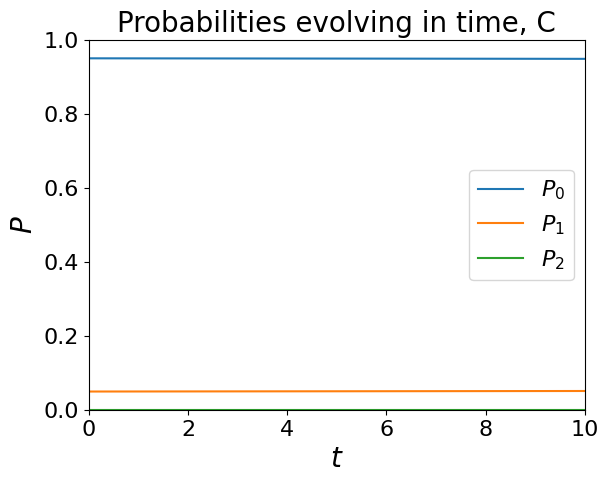

my_rho_1 [0.95077467 0.02461266 0.02461266 0.         0.02461266 0.        ]
sum 1.0
my_rho_2 [ 0.00000000e+00  4.99999157e-01  4.99999157e-01  1.68600214e-06
 -4.99999157e-01  0.00000000e+00]
sum 1.0


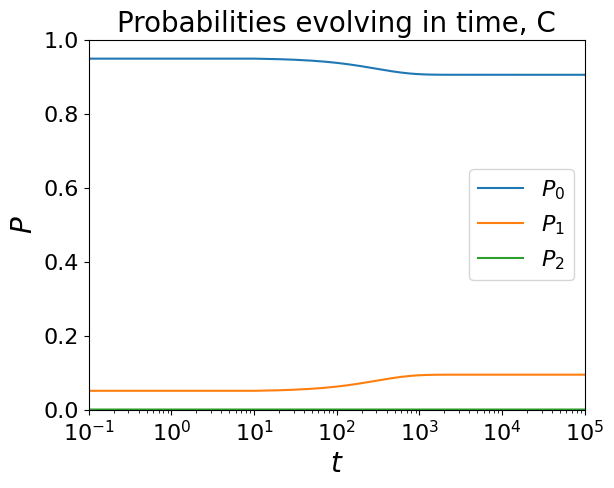

In [7]:
ti_array = np.linspace(0, 1e2, 10000)
do_all(ti_array)
ti_array = np.linspace(0,1e5,10000)
do_all(ti_array, long_time=True)


In [8]:
# -----------------------------PARTICLE CURRENT-------------------------------------

J_QH_tot = np.zeros((nleads,ti_array.shape[0]))
I = np.zeros((ti_array.shape[0]))
I_var = np.zeros((ti_array.shape[0]))


for i in range(ti_array.shape[0]):
    
    # reset current    
    sys.current[:] = np.zeros(nleads)
    sys.energy_current[:] = np.zeros(nleads)
    
    
    # set stationary state to rho_t value
    sys.phi0[:] = np.real(rho_t[:,i])
    
    # calculate current (also calculates energy and heat currents)
    sys.appr.generate_current() # calculates current both ways
    J_QH_tot[:,i] = sys.heat_current
    I[i] = sys.current_noise[0] 
    I_var[i] = sys.current_noise[1]
    
    #--------------------------------------------

# take QmeQ heat current at left lead   
J_QH = J_QH_tot[0]
print('J_QH: ', J_QH)

#Power
P = I*V_B

NameError: name 'nleads' is not defined

In [ ]:
importlib.reload(tc)
TUR, eff_carnot, eff, sigma = tc.calculate_tur(T_L, T_R, I, I_var, J_QH, P)

In [ ]:
print(type(TUR))

<class 'numpy.ndarray'>


3.1104736286516363


Text(0.5, 1.0, 'TUR factor evolving in time 2')

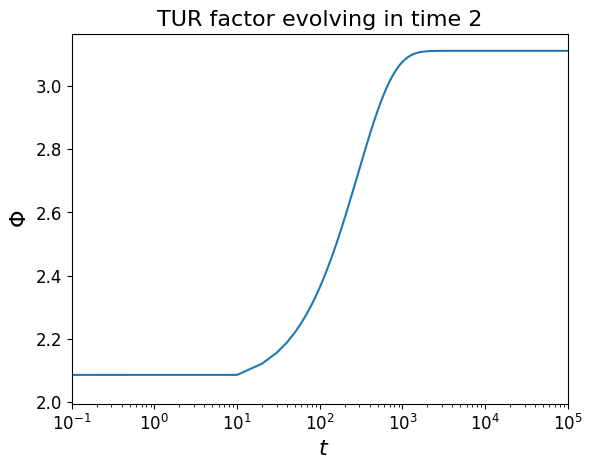

In [ ]:
#PLOT TUR FOR REPORT
plt.rcParams.update({'font.size': 12})  # Applies globally
print(TUR[-1])
plt.plot(ti_array,TUR)
plt.xlabel(r' $t$', fontsize=font_size)
plt.ylabel(r'$\Phi$', fontsize=font_size)
plt.xscale('log')
plt.xlim(1e-1,1e5)
plt.title('TUR factor evolving in time 2', fontsize=font_size)

0.46151547406169996 0.4615308375505899


Text(0.5, 1.0, 'TUR factor')

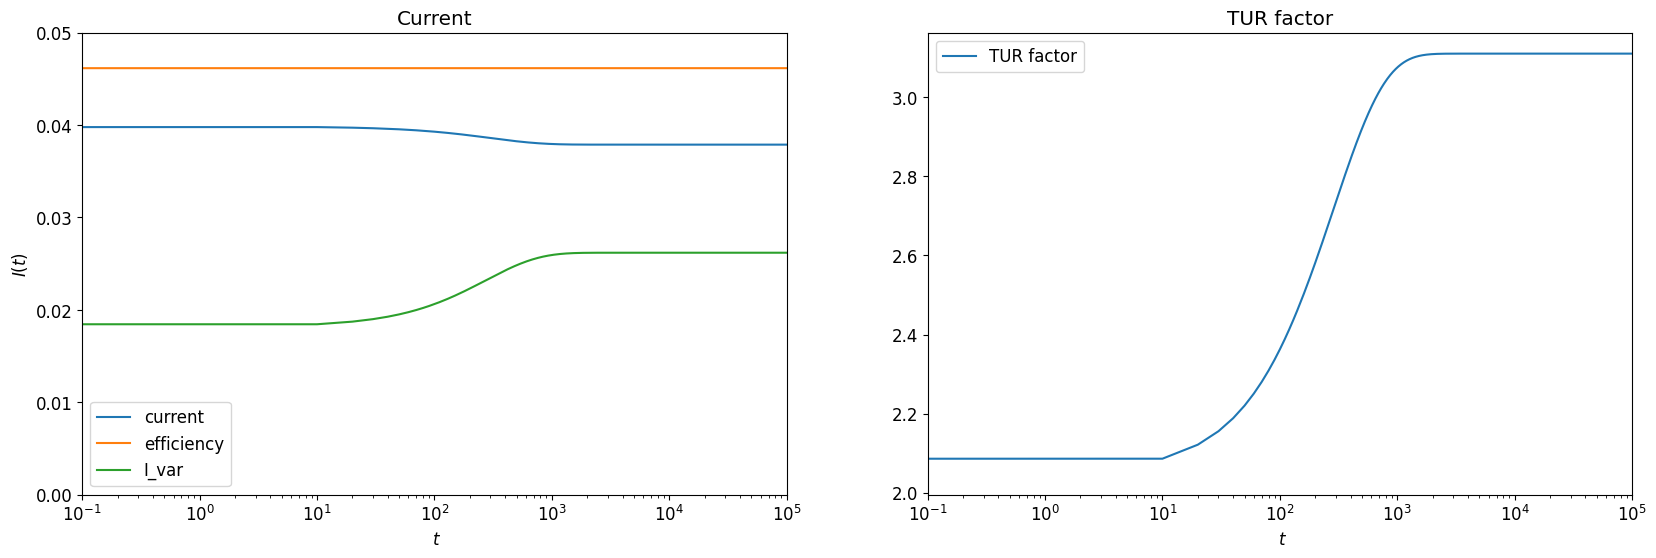

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

ax1.plot(ti_array,I, label = 'current')
ax1.plot(ti_array, 0.1*eff, label='efficiency')
ax1.plot(ti_array, 0.2*I_var, label='I_var')

ax1.legend()

ax1.set_xlabel(r' $t$')
ax1.set_ylabel(r'$I(t)$')
ax1.set_xscale('log')
ax1.set_xlim(1e-1,1e5)
ax1.set_ylim(0, 0.05)
ax1.set_title('Current')

ax2.plot(ti_array,TUR, label = 'TUR factor')
print(np.min(eff), np.max(eff))

ax2.legend()

ax2.set_xlabel(r' $t$')
#ax2.set_ylabel('TUR-factor')
ax2.set_xscale('log')
ax2.set_xlim(1e-1,1e5)
ax2.set_title('TUR factor')